In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn
from scipy.stats import sem
from scipy.stats import pearsonr as pearson_correlation
import pickle as pkl
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
import path_entry
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [ ]:
shuffle_trials = False

# path_entry.get_path() controls the file paths needed for this tutorial. 
# The paths returned by get_path() will need to be adjusted, as they are
# almost certainly unique to your computer
data_root, manifest_path, save_path = path_entry.get_path()
SAVE = False

navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])
with open(f"{save_path}/{stim}__whole_burst_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    bursts = pkl.load(f)
with open(f"{save_path}/{stim}__whole_single_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    singles = pkl.load(f)

In [ ]:
processor = SessionProcessor.SessionProcessor(session)
decoder_name = processor.construct_decoder(
    'drifting_gratings_contrast',
    'orientation',
    burst_dict=bursts,
    single_dict=singles,
    shuffle_trials=shuffle_trials
    )

In [12]:
processor.construct_psth(decoder_name)
processor.calculate_decoder_weights(decoder_name)
processor.calculate_correlations(decoder_name)

In [14]:
results = processor.results()
results = results[decoder_name]
decoder = results["decoder"]
stim_condition_histograms = results["class_psths"]
spike_train_types = stim_condition_histograms.keys()

stim_table = decoder.stim_table
stim_presentation_ids = stim_table.index.values
unit_ids = processor.all_units
bin_edges = decoder.bin_edges
stim_conditions = decoder.stimulus_conditions

In [ ]:
# Data shape: num_presentations, num_bins, num_units

def correlate_noise(mat):
    # mat: num_presentations x num_units
    num_presentations, num_units = mat.shape
    # Average across the presentations
    expectation = np.array(mat.mean(axis=0))
    variance = np.array(mat.var(axis=0))
    centered_mat = mat-expectation
    covariance = np.dot(centered_mat.T, centered_mat)/num_presentations
    return np.divide(
        covariance,
        np.sqrt(
            np.outer(variance, variance)
            ), 
        out=np.full(covariance.shape, np.nan),
        where=True)

# Initialize relevant variables
num_bins = len(bin_edges) - 1
num_units = len(unit_ids)
num_conditions = len(stim_conditions)
upper_triangle_indices = np.triu_indices(n=num_units, k=1)
num_triangle_indices = len(upper_triangle_indices[0])
noise_correlations = {}

# For whole trains, then bursts, then singles (not necessarily in 
# that order)
for spike_train_type in spike_train_types:
    current_spike_train = stim_condition_histograms[spike_train_type]
    # stim_idx -> indicator for which stim condition
    # (i.e. 45 degrees, 90 degrees, etc.)
    stim_idx = 0
    type_correlations = np.zeros((num_conditions, num_bins, num_triangle_indices))
    # For each stim condition
    for stim_condition in stim_conditions:
        # Get all the activity counts for a particular stimulus condition
        counts = current_spike_train[stim_condition]
        
        # For each bin, calculate the noise correlations, pull the upper triangle,
        # flatten it, and store it for calculations later
        for bin_idx in range(num_bins):
            current_bin = counts[:,bin_idx,:]
            
            # current_bin: num_presentations x num_units
            # current_bin.T * current_bin -> num_units x num_units
            current_corr = correlate_noise(current_bin)[upper_triangle_indices].flatten()#np.dot(current_bin.T, current_bin)[upper_triangle_indices].flatten()
            type_correlations[stim_idx, bin_idx, :] = current_corr
    
        stim_idx += 1
    
    noise_correlations[spike_train_type] = type_correlations
    # type_correlations[idx, :, :] -> all correlations for the idx^th stim condition


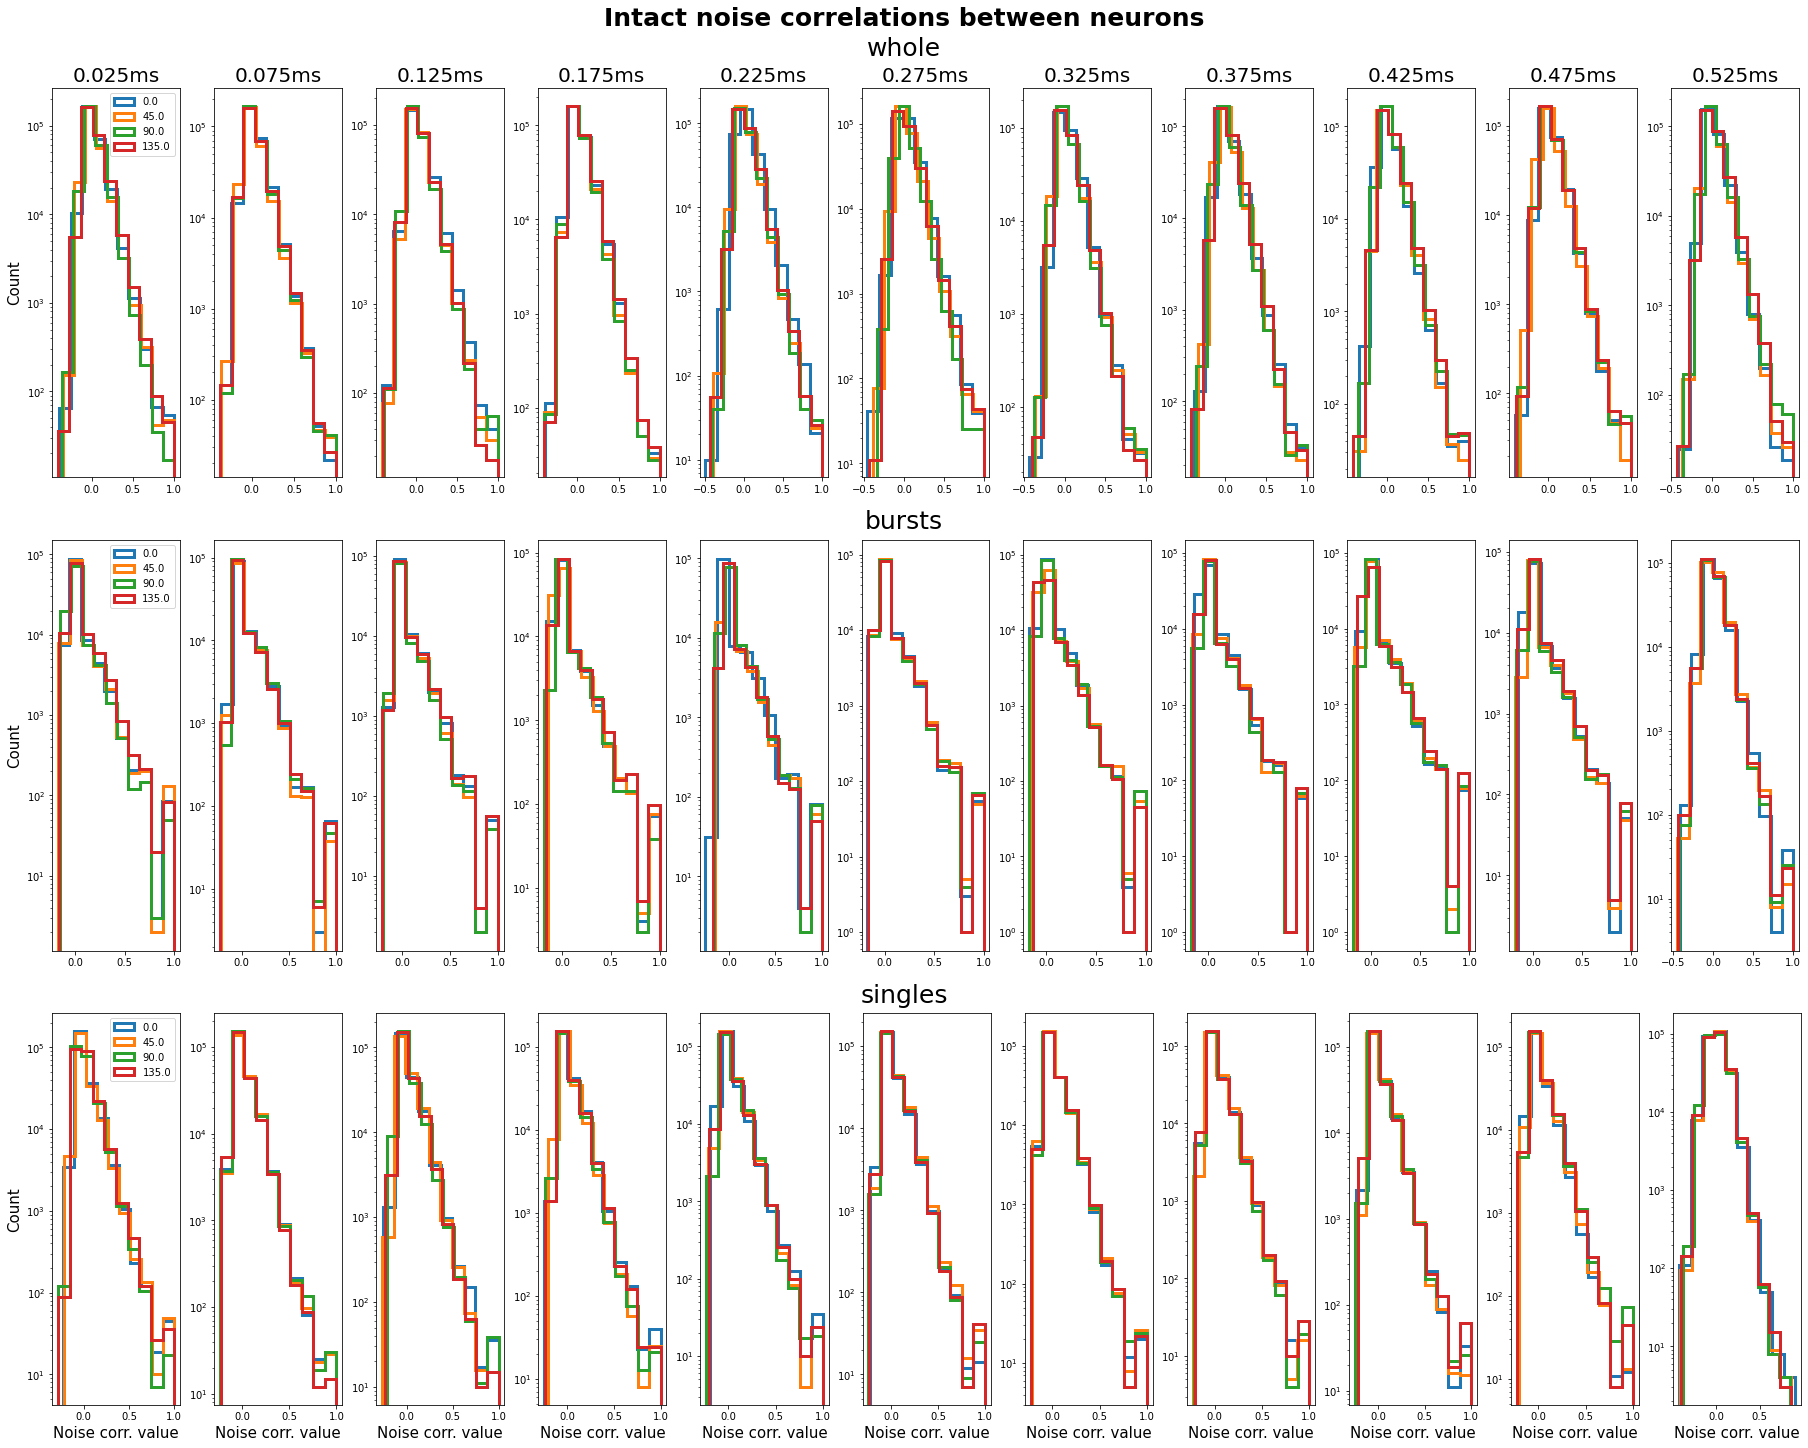

In [16]:
# Assign the plot attributes
TITLE_FONT_SIZE = 20
XY_LABEL_SIZE = 15
X_TICK_SIZE = 10
Y_TICK_SIZE = 10
LEGEND_SIZE = 10
SUPTITLE_SIZE = 25
SUPTITLE_WEIGHT = "bold"
LINEWIDTH = 3
BIN_WIDTH = bin_edges[1] - bin_edges[0]
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (25, 20)
matplotlib.rcParams["figure.titlesize"] = SUPTITLE_SIZE
matplotlib.rcParams["figure.titleweight"] = SUPTITLE_WEIGHT
plt.rc('axes', titlesize=TITLE_FONT_SIZE)
plt.rc('axes', labelsize=XY_LABEL_SIZE)
plt.rc('xtick', labelsize=X_TICK_SIZE)
plt.rc('ytick', labelsize=Y_TICK_SIZE)
plt.rc('legend', fontsize=LEGEND_SIZE)

fig = plt.figure(constrained_layout=True)
# "Intact noise correlations between neurons"
# Noise correlations between neurons after trial shuffling
super_title = "Noise correlations between neurons after trial shuffling" if shuffle_trials else "Intact noise correlations between neurons"
fig.suptitle(super_title)
subfigs = fig.subfigures(nrows=3, ncols=1)
row = -1
#for spike_train_type, type_correlations in noise_correlations.items():
    # Make a new figure
for spike_train_type, type_correlations in noise_correlations.items():   
    row += 1
    subfig = subfigs[row]
    axs = subfig.subplots(nrows=1, ncols=num_bins)#, sharex=True, sharey=True)
    subfig.suptitle(spike_train_type, fontweight="normal")
    
    for bin_idx, ax in enumerate(axs):
        # ax[bin_idx]
        for stim_idx, stim_condition in zip(range(num_conditions), stim_conditions):
            # ax[bin_idx].plot(...,label=current_condition)
            # type_correlations.shape = (num_conditions, num_bins, num_correlation_values)
            #plottable_correlations = type_correlations[stim_idx, bin_idx, :]
            ax.hist(type_correlations[stim_idx, bin_idx, :], histtype="step", log=True, label=stim_condition, linewidth=LINEWIDTH)
            
            if spike_train_type == "whole":
                ax.set_title(f"{BIN_WIDTH*(bin_idx + 1/2):{4}.{3}}ms")
            elif spike_train_type == "singles":
                ax.set_xlabel("Noise corr. value")
            
    axs[0].set_ylabel("Count")
    axs[0].legend()

# "noise_correlations_after_shuffling"
# "intact_noise_correlations"
save_name = "noise_correlations_after_shuffling" if shuffle_trials else "intact_noise_correlations"
if SAVE: plt.savefig(f"{save_path}/{save_name}.png", dpi=500, facecolor="white", bbox_inches="tight")
plt.show()